### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [4]:
from os.path import isdir
from os import mkdir

env = 'colab'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/full_testing/'
experiment = 'Exp3/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

In [5]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

# Saving directory

In [6]:
full_dir = f'{save_dir}{experiment}'
assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))

In [7]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [8]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [9]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

In [10]:
# %%timeit
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)


def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

In [18]:
# %%timeit

# Old inefficient weights calculation
# weights = calc_weight_matrix(X, weight_func = None)

from sklearn.metrics import pairwise_distances

weights = pairwise_distances(X, metric = 'euclidean')
weights = 1 / (pair_weights + 0.001)
assert(weights.shape == (DataProperties.n_samples, DataProperties.n_samples))

Data shape: X: (5000, 2), Y: (5000,)


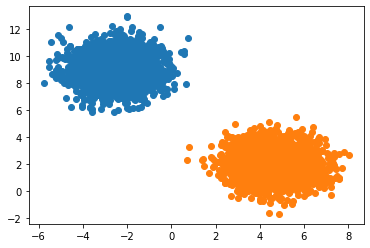

In [12]:
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 2500 instances of object 0.0
We have to delabel 2375 instances
Found 2500 instances of object 1.0
We have to delabel 2375 instances

    We have 4750 unlabeled data
    Out of 5000
    


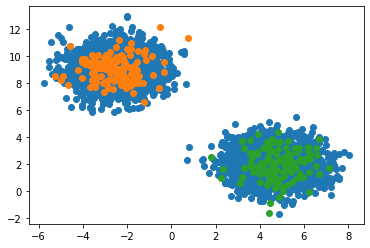

In [13]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [15]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled
print(class_stats)

Counter({-1000000.0: 4750, 1.0: 125, 0.0: 125})


# Gradient descent

In [25]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.00001
)

In [27]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 15,
    delta_loss_limit = 0.008, 
    stop_loss = 150,
    weight_matrix = weights
)

Iteration: 0, Loss: 1761360.4200700333, delta loss: 1761360.4200700333
Iteration: 1, Loss: 1735154.3172182278, delta loss: 26206.10285180551
Iteration: 2, Loss: 1735037.9463347571, delta loss: 116.370883470634
Iteration: 3, Loss: 1735021.4502049692, delta loss: 16.496129787992686
Iteration: 4, Loss: 1735016.980884067, delta loss: 4.469320902135223
Iteration: 5, Loss: 1735014.331794235, delta loss: 2.649089832091704
Iteration: 6, Loss: 1735012.0791837336, delta loss: 2.2526105013675988
Iteration: 7, Loss: 1735009.9982284906, delta loss: 2.0809552429709584
Iteration: 8, Loss: 1735008.0458236139, delta loss: 1.952404876705259
Iteration: 9, Loss: 1735006.2087508799, delta loss: 1.837072734022513


KeyboardInterrupt: ignored

Accuracy: 1.0


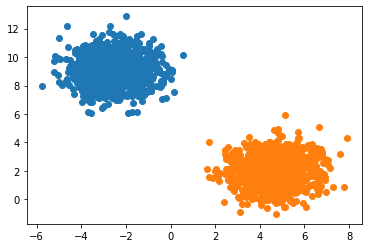

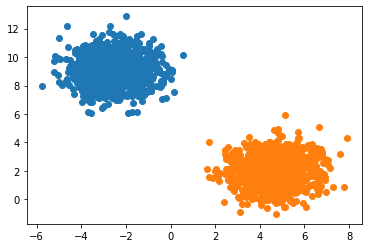

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

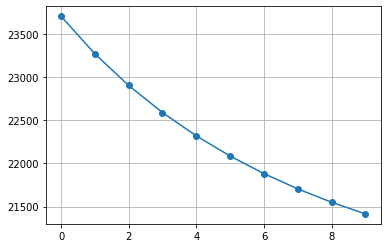

In [ ]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [ ]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00013,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [ ]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 10,
    delta_loss_limit = 0.008,
    stop_loss= 2174,
    weight_matrix = weights
)

Iteration: 0, Loss: 23705.246199587826, Delta: 23705.246199587826
Iteration: 1, Loss: 23223.81504605525, Delta: 481.431153532576
Iteration: 2, Loss: 22824.565553842705, Delta: 399.2494922125443
Iteration: 3, Loss: 22489.28354099078, Delta: 335.282012851927
Iteration: 4, Loss: 22205.32170103817, Delta: 283.961839952608
Iteration: 5, Loss: 21963.34971168953, Delta: 241.9719893486399
Iteration: 6, Loss: 21756.24401036307, Delta: 207.1057013264617
Iteration: 7, Loss: 21578.42304678896, Delta: 177.82096357410774
Iteration: 8, Loss: 21425.37353456276, Delta: 153.04951222620002
Iteration: 9, Loss: 21293.419202719168, Delta: 131.95433184359354


Accuracy: 1.0


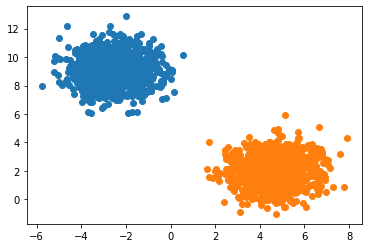

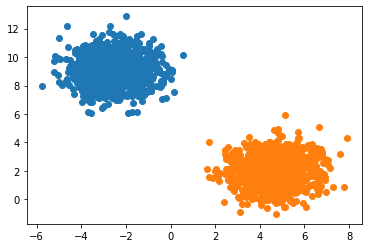

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

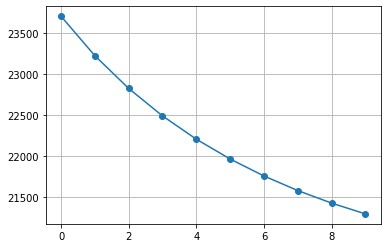

In [ ]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

## BCGD random sampling

In [ ]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00013,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [ ]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled,
    iter_limit = 10 * len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]),
    delta_loss_limit = 0.0,
    stop_loss= 21000,
    weight_matrix = weights
)

Iteration: 0, Loss: 23705.246199587826, Delta: 23705.246199587826
Iteration: 1, Loss: 23705.13573489805, Delta: 0.11046468977656332
Iteration: 2, Loss: 23705.080336536463, Delta: 0.05539836158641265
Iteration: 3, Loss: 23704.88460622157, Delta: 0.1957303148919891
Iteration: 4, Loss: 23704.80739225993, Delta: 0.07721396164197358
Iteration: 5, Loss: 23704.506344229012, Delta: 0.30104803091671783
Iteration: 6, Loss: 23704.188038098782, Delta: 0.3183061302297574
Iteration: 7, Loss: 23703.916768351162, Delta: 0.2712697476199537
Iteration: 8, Loss: 23703.737879165285, Delta: 0.1788891858777788
Iteration: 9, Loss: 23703.604110764787, Delta: 0.13376840049750172
Iteration: 10, Loss: 23703.480429485917, Delta: 0.12368127887020819
Iteration: 11, Loss: 23703.32458267676, Delta: 0.15584680915708304
Iteration: 12, Loss: 23702.96034329982, Delta: 0.36423937694053166
Iteration: 13, Loss: 23702.92790611682, Delta: 0.03243718299927423
Iteration: 14, Loss: 23702.697060606424, Delta: 0.23084551039573853
I

KeyboardInterrupt: ignored

Accuracy: 0.5455


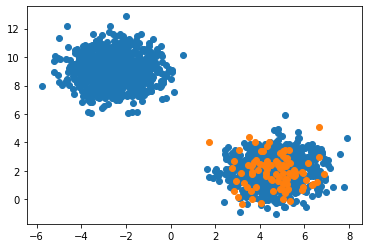

In [ ]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

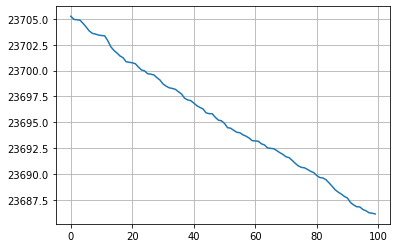

In [ ]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [ ]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00013,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [ ]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 10, 
    delta_loss_limit = 0.0001,
    stop_loss = 2300,
    weight_matrix = weights
)

Iteration: 0, Loss: 23705.246199587826, Delta: 23705.246199587826
Iteration: 1, Loss: 23223.87541605323, Delta: 481.37078353459583
Iteration: 2, Loss: 22824.57099074438, Delta: 399.3044253088483
Iteration: 3, Loss: 22489.047186548425, Delta: 335.5238041959565
Iteration: 4, Loss: 22204.67782381175, Delta: 284.3693627366738
Iteration: 5, Loss: 21962.239960690094, Delta: 242.43786312165685
Iteration: 6, Loss: 21754.694939378154, Delta: 207.54502131194022
Iteration: 7, Loss: 21576.492399138595, Delta: 178.2025402395593
Iteration: 8, Loss: 21423.1495535696, Delta: 153.34284556899365
Iteration: 9, Loss: 21290.982280337736, Delta: 132.1672732318657


Accuracy: 1.0


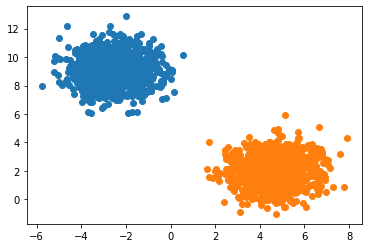

In [ ]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

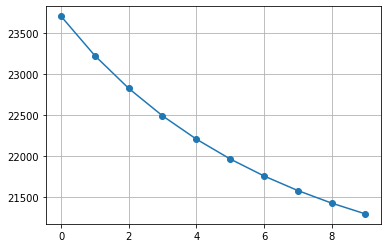

In [ ]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [ ]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.00013

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [ ]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        print(f'Fitting {model_name}')
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [ ]:
iters_limit = 17
delta_loss_limit = 0.0001
stop_loss= 21000  # 4000


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled,
        iters_limit = iters_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

Iteration: 0, Loss: 23705.246199587826, delta loss: 23705.246199587826
Iteration: 1, Loss: 23270.092865418654, delta loss: 435.153334169172
Iteration: 2, Loss: 22902.916059786145, delta loss: 367.17680563250906
Iteration: 3, Loss: 22589.309011406975, delta loss: 313.60704837917
Iteration: 4, Loss: 22319.274015837444, delta loss: 270.034995569531
Iteration: 5, Loss: 22085.464733599736, delta loss: 233.80928223770752
Iteration: 6, Loss: 21882.234397208733, delta loss: 203.23033639100322
Iteration: 7, Loss: 21705.092162468358, delta loss: 177.142234740375
Iteration: 8, Loss: 21550.37521252989, delta loss: 154.71694993846904
Iteration: 9, Loss: 21415.040186768176, delta loss: 135.33502576171304
Iteration: 10, Loss: 21296.52371664043, delta loss: 118.51647012774629
Iteration: 11, Loss: 21192.64485000277, delta loss: 103.8788666376604
Iteration: 12, Loss: 21101.534003470173, delta loss: 91.11084653259604
Iteration: 13, Loss: 21021.57942379962, delta loss: 79.95457967055336
Iteration: 14, Los

## Saving data

In [ ]:
# iters_limit = 17
# delta_loss_limit = 0.0001
# stop_loss= 21000  # 4000

experiment_params = pd.DataFrame(
    {
        'iters_limit': [iters_limit],
        'd_loss_limit': [delta_loss_limit],
        'stop_loss': [stop_loss],
        'learning_rate': [lr],
        'n points': [DataProperties.n_samples]
    },
    # index = False
)

experiment_params.head()
experiment_params.to_csv(full_dir + 'experiment_params.csv')

In [ ]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    new = pd.DataFrame({model_name: loss})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    new = pd.DataFrame({model_name: cpu_time})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} cpu'] = cpu_time


results.to_csv(full_dir + 'res.csv')
results.head()

,GD,BCGD permutation,BCGD cyclic,BCGD sampling,GD,BCGD permutation,BCGD cyclic,BCGD sampling
0,23705.246200,23705.246200,23705.246200,23705.246200,5.635540,5.437176,5.333421,5.433127
1,23270.092865,23223.775247,23223.875416,23705.170931,19.309244,15.754048,15.660645,10.837491
2,22902.916060,22824.514146,22824.570991,23705.101050,30.997254,27.270268,26.017488,16.262824
3,22589.309011,22489.270457,22489.047187,23704.929295,44.408678,37.943570,36.545720,21.717687
4,22319.274016,22205.339109,22204.677824,23704.845528,55.274320,48.697463,46.974563,27.185088


['CPU total time_norm', 'N iterations_norm', 'Accuracies_norm']


,CPU total time,N iterations,Accuracies,CPU total time_norm,N iterations_norm,Accuracies_norm
GD,162.048237,14,1.00,1.000000,0.823529,1.00
BCGD permutation,132.902810,12,1.00,0.820144,0.705882,1.00
BCGD cyclic,131.656900,12,1.00,0.812455,0.705882,1.00
BCGD sampling,92.054720,17,0.53,0.568070,1.000000,0.53


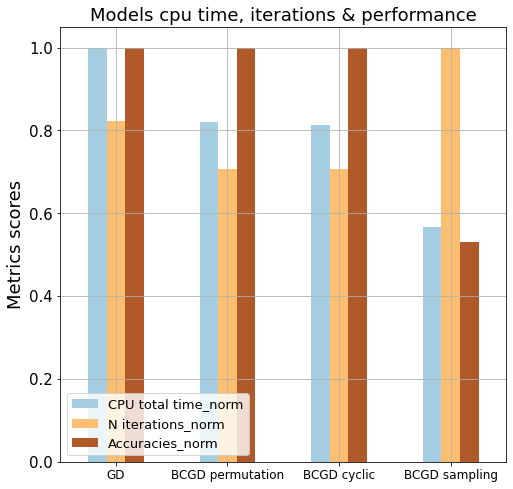

In [ ]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

print(cols_to_plot)

normalize_cols(bar_metrics)
cols_to_plot = [c for c in bar_metrics.columns if 'norm' in c]

plot_bar_metrics(bar_metrics.loc[:, cols_to_plot])
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

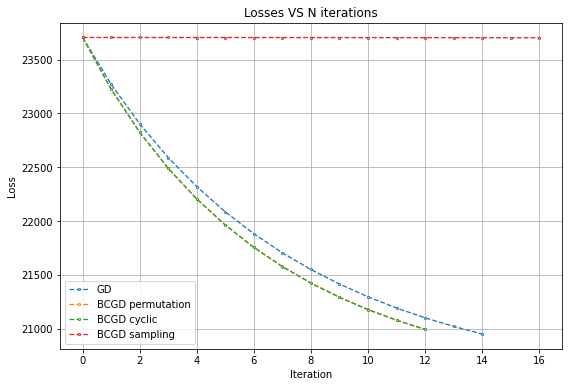

In [ ]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

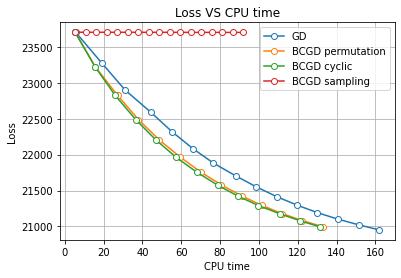

In [ ]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)


# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


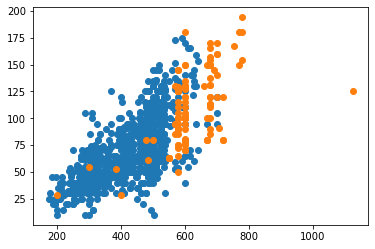

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

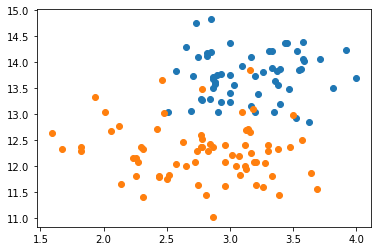

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


